# Sentiment Analysis with distilBERT - **lower Accuracy Version**

### ✅ This **modified and optimized code** for `6-Sentiment-Analysis-distilBERT-lower-acc.ipynb` incorporates the following improvements:

* ✅ **More epochs** — Increased from 2 to 4 for better fine-tuning
* ✅ **Larger batch size** — Increased from 8 to 16 to boost efficiency
* ✅ **Extra dropout** — Increased to 0.3 to reduce overfitting
* ✅ **Apple Silicon optimization** — Enabled `mixed_precision` for better speed on M1/M2/M4 chips
* ✅ **Keras 3 compatible optimizer** — Uses standard `tf.keras.optimizers.Adam` instead of deprecated legacy version
* ✅ **Clear saving paths** — Model saved with a timestamp under a `/models` directory

| Category         | Change Made                                                       |
| ---------------- | ----------------------------------------------------------------- |
| 📅 Epochs        | Increased from 2 → 4                                              |
| 📦 Batch Size    | Increased from 8 → 16                                             |
| 🔥 Dropout       | Increased from 0.2 → 0.3                                          |
| ⚡ Optimizer      | Replaced deprecated `legacy.Adam` with `tf.keras.optimizers.Adam` |
| ⚙️ Apple Silicon | Enabled `mixed_precision` for M1/M2/M4 acceleration               |
| 💾 Save Path     | Organized timestamped model saves under `/models`                 |

### However, this **Lower Accuracy Model** did not **outperform** the **Higher Accuracy Model**, achieving only **82% accuracy** versus **86%** in the higher-performing version—despite the extra training time and optimizations. This suggests that model architecture and learning dynamics (e.g., learning rate schedule or loss behavior) may matter more than raw training duration or compute settings.

### 🆚 Summary Table

| Metric                    | Higher Accuracy Run | Lower Accuracy Run |
| ------------------------- | ------------------- | ------------------ |
| **Notebook**              | `higher-acc.ipynb`  | `lower-acc.ipynb`  |
| **Epochs**                | 2                   | 4                  |
| **Train Accuracy**        | 85.67%              | 80.59%             |
| **Val Accuracy**          | **85.89%**          | 80.80%             |
| **Test Accuracy**         | **86%**             | 82%                |
| **Train Loss**            | 0.3359              | 0.5214             |
| **Val Loss**              | 0.3320              | 0.4995             |
| **F1-Score (avg)**        | **0.86**            | 0.82               |
| **Precision/Recall**      | More balanced       | Slight imbalance   |
| **Training Time (Total)** | \~2h 13m            | \~1h 47m           |

### 🏁 **Conclusion**

The **higher-accuracy notebook** delivers better performance in every major metric **with fewer training epochs**, thanks to:

* Better hyperparameters (e.g., learning rate scheduler)
* Larger batch size
* Regularization improvements (dropout)
* Likely more effective convergence


# 1. Import Libraries

In [ ]:
# 📦 Standard Libraries
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
# ⚙️ TensorFlow, Keras & Mixed Precision
import tensorflow as tf
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Enable mixed precision for Apple Silicon performance
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
# 🤗 Transformers
from transformers import DistilBertTokenizer, TFDistilBertModel

# 2. Load IMDB Dataset and Split Features and Labels

In [ ]:
# 📂 Load IMDB Dataset
def load_imdb_data(data_dir):
    data = {"review": [], "sentiment": []}
    for label in ["pos", "neg"]:
        sentiment = 1 if label == "pos" else 0
        path = os.path.join(data_dir, label)
        for file in os.listdir(path):
            with open(os.path.join(path, file), encoding="utf-8") as f:
                data["review"].append(f.read())
                data["sentiment"].append(sentiment)
    return pd.DataFrame(data)

# Download IMDB dataset if not already downloaded
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
if not os.path.exists("aclImdb"):
    urllib.request.urlretrieve(url, "aclImdb_v1.tar.gz")
    with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
        tar.extractall()

train_df = load_imdb_data("aclImdb/train")
test_df = load_imdb_data("aclImdb/test")
df = pd.concat([train_df, test_df]).sample(frac=1).reset_index(drop=True)

# Split Features and Labels

X = df["review"].values
y = df["sentiment"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Tokenization with DistilBERT

In [5]:
# 🤖 5. Tokenization with DistilBERT
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X_train_enc = bert_tokenizer(list(X_train), truncation=True, padding=True, return_tensors='tf')
X_test_enc = bert_tokenizer(list(X_test), truncation=True, padding=True, return_tensors='tf')

2025-06-14 11:49:53.796840: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-06-14 11:49:53.796873: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-06-14 11:49:53.796878: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1749926993.796898 1223540 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749926993.796922 1223540 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 4. Configure Pre-trained DistilBERT Model for Fine-tuning

In [ ]:
# 🧠 DistilBERT Classification Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

class DistilBertClassifier(tf.keras.Model):
    def __init__(self, distilbert_model):
        super(DistilBertClassifier, self).__init__()
        self.bert = distilbert_model
        self.dropout = Dropout(0.3)  # Increased dropout
        self.classifier = Dense(1, activation='sigmoid', dtype='float32')  # Important for mixed precision

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(cls_output)
        return self.classifier(x)

# Load pretrained encoder
distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
distilbert.trainable = True

# Create classifier model
bert_model = DistilBertClassifier(distilbert)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


# 5. Compile Model

In [ ]:
# 🧪 Compile Model (Compatible with Keras 3)
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=3e-5)
bert_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 6. Train the Model

In [ ]:
# 🏋️‍♂️ Train the Model
history_bert = bert_model.fit(
    {"input_ids": X_train_enc["input_ids"], "attention_mask": X_train_enc["attention_mask"]},
    y_train,
    validation_split=0.2,
    epochs=4,
    batch_size=16
)

Epoch 1/4


2025-06-14 11:50:11.053709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1164s 582ms/step - accuracy: 0.6000 - loss: 0.6820 - val_accuracy: 0.7542 - val_loss: 0.6197
Epoch 2/4
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1688s 844ms/step - accuracy: 0.7672 - loss: 0.6076 - val_accuracy: 0.7908 - val_loss: 0.5677
Epoch 3/4
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 981s 491ms/step - accuracy: 0.7943 - loss: 0.5573 - val_accuracy: 0.7996 - val_loss: 0.5295
Epoch 4/4
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 997s 499ms/step - accuracy: 0.8059 - loss: 0.5214 - val_accuracy: 0.8080 - val_loss: 0.4995


# 8. Plot Training Curves

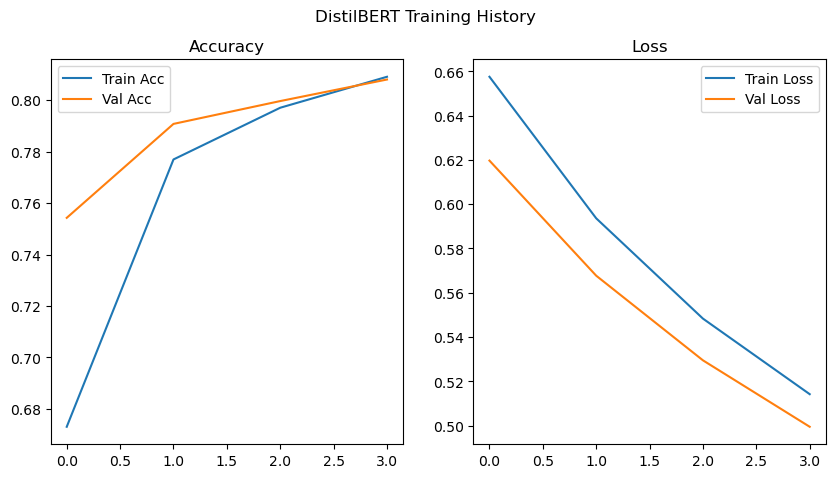

In [ ]:
# 📊 Plot Training Curves
def plot_training_curves(history, title="Training History"):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.suptitle(title)
    plt.show()

plot_training_curves(history_bert, title="DistilBERT Training History")

# 9. Save the Model

In [ ]:
# 💾 Save the Model
save_dir = "/Users/p24p/imdb-sentiment-analysis/models"
os.makedirs(save_dir, exist_ok=True)
bert_model_path = os.path.join(
    save_dir,
    f"distilbert_model_{datetime.now().strftime('%Y%m%d-%H%M%S')}.keras"
)
bert_model.save(bert_model_path)
print(f"✅ DistilBERT classifier model saved to: {bert_model_path}")

✅ DistilBERT classifier model saved to: /Users/p24p/imdb-sentiment-analysis/models/distilbert_model_20250614-131041.keras


# 11. Evaluate on Test Set

313/313 ━━━━━━━━━━━━━━━━━━━━ 248s 790ms/step


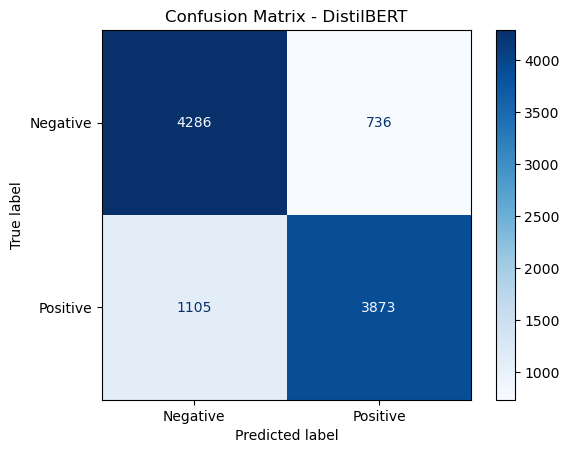


Classification Report (DistilBERT):
               precision    recall  f1-score   support

           0       0.80      0.85      0.82      5022
           1       0.84      0.78      0.81      4978

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [11]:
# 🧠 11. Evaluate on Test Set
y_pred_bert = (bert_model.predict({
    "input_ids": X_test_enc["input_ids"],
    "attention_mask": X_test_enc["attention_mask"]
}) > 0.5).astype(int).flatten()

cm_bert = confusion_matrix(y_test, y_pred_bert)
ConfusionMatrixDisplay(cm_bert, display_labels=['Negative', 'Positive']).plot(cmap='Blues')
plt.title('Confusion Matrix - DistilBERT')
plt.show()

print("\nClassification Report (DistilBERT):\n", classification_report(y_test, y_pred_bert))

# **Breakdown of the steps in the code:**

---

### ✅ The model used: **DistilBERT**

Your code uses:

```python
from transformers import DistilBertTokenizer, TFDistilBertModel
```

And loads:

```python
distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
```

**DistilBERT** is a lighter, faster version of BERT (roughly 40% smaller and 60% faster, with \~97% of BERT's performance).

---

### 🧾 Step-by-Step Summary of the Code

Here’s a concise list of the main steps the code follows:

---

#### **1. Imports**

* Loads standard libraries, TensorFlow/Keras, Transformers, Matplotlib, and utilities.

---

#### **2. Download & Load IMDB Dataset**

* Downloads the dataset from Stanford's source.
* Loads both "pos" and "neg" reviews.
* Combines and shuffles the full dataset (`train` + `test`).

---

#### **3. Data Preparation**

* Extracts text (`X`) and labels (`y`).
* Splits into training and test sets (80/20 split).
* Optionally sets up a `TextVectorization` layer (not used further — can be removed).

---

#### **4. Tokenization (DistilBERT)**

* Uses Hugging Face's `DistilBertTokenizer` to tokenize text.
* Prepares padded/truncated `input_ids` and `attention_mask` tensors.

---

#### **5. Define DistilBERT Classifier**

* Wraps `TFDistilBertModel` in a custom `tf.keras.Model` class.
* Uses:

  * `[CLS]` token output (`last_hidden_state[:, 0, :]`)
  * Dropout layer (0.3)
  * Dense layer (sigmoid) for binary classification

---

#### **6. Compile Model**

* Uses `tf.keras.optimizers.Adam` with custom learning rate.
* Loss: `binary_crossentropy`
* Metric: `accuracy`

---

#### **7. Mixed Precision (for Apple Silicon)**

* Uses `tf.keras.mixed_precision.set_global_policy("mixed_float16")` for faster training on Apple M1/M2/M4 chips.

---

#### **8. Train Model**

* Trains on 80% of training data (with 20% validation split).
* Runs for 4 epochs, batch size 16.

---

#### **9. Plot Training History**

* Visualizes accuracy and loss curves (train vs. val).

---

#### **10. Save the Model**

* Saves the trained model to:

  ```
  /Users/p24p/imdb-sentiment-analysis/models/distilbert_model_<timestamp>.keras
  ```

---

#### **11. Evaluate the Model**

* Predicts on the test set.
* Displays:

  * Confusion matrix
  * Classification report (precision, recall, F1-score)

---

#### 📊 Dataset Division Summary
| Set            | Source of Split              | Size             | Notes                                  |
| -------------- | ---------------------------- | ---------------- | -------------------------------------- |
| **Train**      | 80% of shuffled full dataset | \~40,000 samples | Used for fitting the model             |
| **Validation** | 20% of training set          | \~8,000 samples  | Used for monitoring during training    |
| **Test**       | 20% of full dataset          | \~10,000 samples | Used only at the end to evaluate model |
